In [1]:
import pandas as pd
import numpy as np

In [2]:
dtrain = pd.read_csv('evo_train.csv')

## Metadata

In [3]:
target_label = u'GROUP_ID'
pred_labels = u'NAME'

## Preparing data ##

In [4]:
target = dtrain[target_label]
preds = dtrain[pred_labels]

### Partition

In [5]:
import sklearn
sklearn.__version__

'0.17.1'

In [6]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    preds, target, 
    test_size=0.33, 
    random_state=42)

In [28]:
def check_accuracy(clf):
    clf.fit(X_train, y_train)
    t = clf.predict(X_test)
    from sklearn.metrics import accuracy_score
    print "clf_v4 - accuracy_score: %f" % accuracy_score(y_test, t)

## Model

### Baseline ###

create baseline model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
baseline_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB())])


teach baseline model

In [ ]:
baseline_clf = baseline_clf.fit(X_train, y_train)

predict target on test

In [ ]:
y_pred = baseline_clf.predict(X_test)

calculate score

In [ ]:
from sklearn.metrics import accuracy_score
print "accuracy_score: %f" % accuracy_score(y_test, y_pred)

## Analysis

In [ ]:
check = pd.DataFrame({
        "name": X_test,
        "y_test": y_test,
        "y_pred": y_pred
    })

In [ ]:
check_incorrect = check[check.y_pred != check.y_test]

In [ ]:
check_incorrect["link"] = check_incorrect.y_pred.astype("str") + " => " + check_incorrect.y_test.astype("str")

In [ ]:
dcats = pd.read_csv('categories.csv')

In [ ]:
t = check_incorrect.merge(dcats[["GROUP_ID","NAME"]], 
                          how='left', 
                          left_on="y_test",
                          right_on="GROUP_ID", 
                          suffixes=('', '_test'))

t = t.drop(["GROUP_ID"], axis=1)
t = t.merge(dcats[["GROUP_ID","NAME"]], 
            how='left', 
            left_on="y_pred", 
            right_on="GROUP_ID", 
            suffixes=('_test', '_pred'))
t = t.drop(["GROUP_ID"], axis=1)
t

## TRY 2

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_v2 = Pipeline([('vect', CountVectorizer(analyzer=u'char', ngram_range=(1,5))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB())])

In [ ]:
clf_v2 = clf_v2.fit(X_train, y_train)
y_pred_v2 = clf_v2.predict(X_test)
from sklearn.metrics import accuracy_score
print "clf_v2 - accuracy_score: %f" % accuracy_score(y_test, y_pred_v2)

## TRY 3

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_v3 = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer(use_idf=False)),
                   ('clf', MultinomialNB())])

In [ ]:
clf_v3.fit(X_train, y_train)
y_pred_v3 = clf_v3.predict(X_test)
from sklearn.metrics import accuracy_score
print "clf_v3 - accuracy_score: %f" % accuracy_score(y_test, y_pred_v3)

## TRY 4

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
clf_v4 = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer(use_idf=False)),
                   ('clf', SGDClassifier(loss='hinge', 
                                         penalty='l2',
                                         alpha=1e-3, 
                                         n_iter=5, 
                                         random_state=42))])

In [ ]:
check_accuracy(clf_v4)

In [ ]:
t = dcats.sort_values(by='GROUP_ID').join(pd.Series(sorted(y_test.unique()), name='DESC'))
labels = dcats.sort_values(by='GROUP_ID')['NAME']

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_v4))

In [ ]:
clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf=False))])
df = clf.fit_transform(X_train)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

transform = Pipeline([('vect', CountVectorizer(min_df=0.0001)),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('scale', StandardScaler(with_mean=False))])

df = transform.fit_transform(X_train)
df.shape

(37426, 7369)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

clf = Pipeline([('vect', CountVectorizer(min_df=0.0001)),
          ('tfidf', TfidfTransformer(use_idf=False)),
          ('scale', StandardScaler(with_mean=False)),
          ('clf', SGDClassifier(loss='hinge', 
                                penalty='l2',
                                alpha=1e-3, 
                                n_iter=5, 
                                random_state=42))])

check_accuracy(clf)

In [8]:
df.shape

(37426, 7369)

In [9]:
import matplotlib as plt
%matplotlib inline

In [10]:
X = df.toarray()

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X[:10000])

print('Projecting %d-dimensional data to 2D' % X.shape[1])

# plt.figure(figsize=(12,10))
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
#             edgecolor='none', alpha=0.7, s=40,
#             cmap=plt.cm.get_cmap('nipy_spectral', 10))
# plt.colorbar()
# plt.title('MNIST. PCA projection')

Projecting 7369-dimensional data to 2D


In [20]:
plt.figure.f

AttributeError: 'module' object has no attribute 'figure'

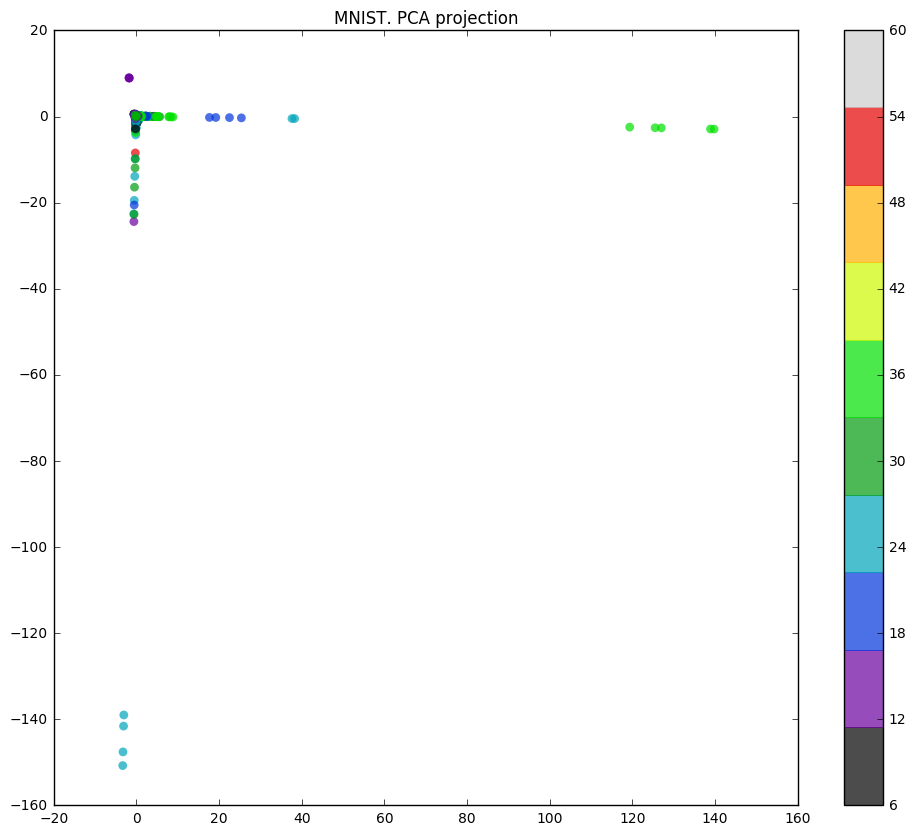

In [24]:
import pylab as plt
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train[:10000], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection')

Wall time: 45min 22s


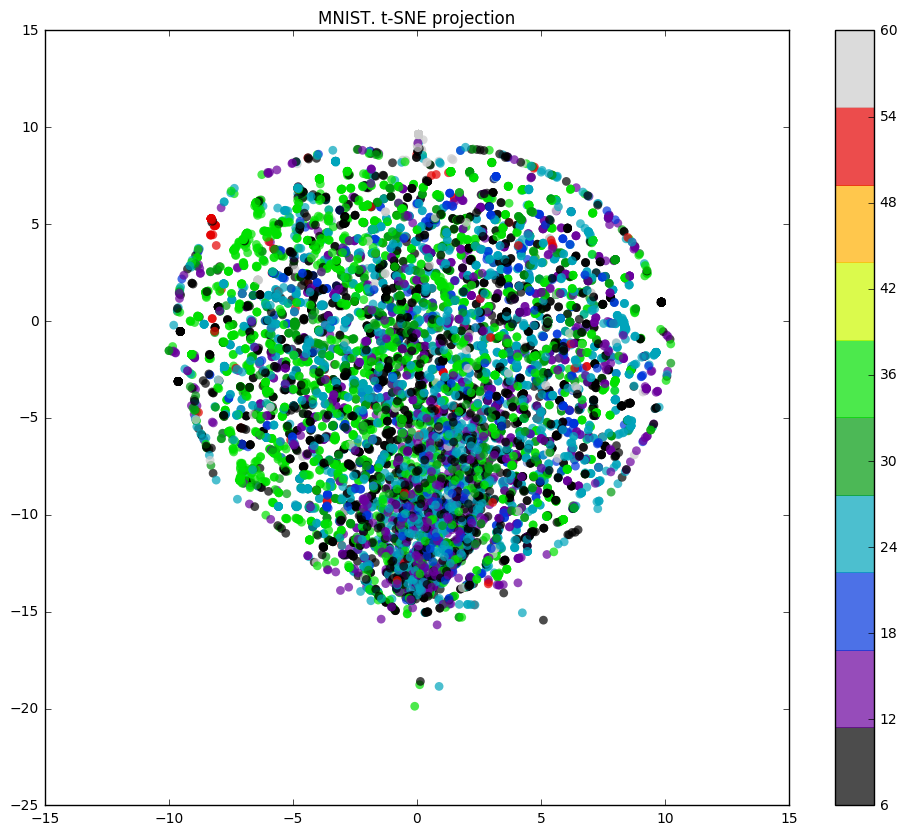

In [25]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X[:10000])

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[:10000], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

In [26]:
dtrain.GROUP_ID.value_counts()

7     6045
6     6014
24    5975
14    5972
34    5963
35    5957
30    3050
26    2999
25    2961
29     639
28     633
9      626
37     618
17     616
18     613
16     612
20     608
59     607
27     606
19     604
22     603
21     587
52     586
60     584
36     572
12     568
38     394
15     235
32      13
Name: GROUP_ID, dtype: int64

In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([('vect', CountVectorizer(min_df=0.0001)),
          ('tfidf', TfidfTransformer(use_idf=False)),
          ('scale', StandardScaler(with_mean=False)),
          ('clf', LogisticRegression())])

check_accuracy(clf)

clf_v4 - accuracy_score: 0.894217
